In [1]:
import numpy as np
import matplotlib.pyplot as plt
#TODO: - tune epsilon?
#      - what is C and A?
#      - leap-frog in SG methods?
#      - fisher information in SGLD?
# change step size in 3_1 to compare diff. HMC
#    - ACF
#    - ESS normalized / time
# in calc KL divergence: downsample HMC

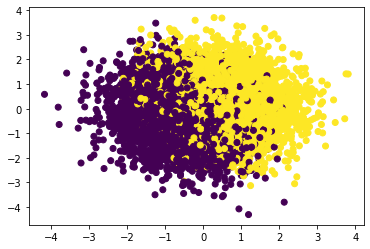

In [2]:
data = np.load("./mcs_hw2_p3_data.npy")
X = data[:, :2]
Y = data[:, -1]
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [3]:
def logit(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def potential_energy(beta, X, Y):
    likelihood_prior = -0.5 * np.sum(beta ** 2)
    likelihood_data = Y.T @ X @ beta - np.sum(np.log(1 + np.exp(X @ beta)))
    return -likelihood_prior - likelihood_data

In [5]:
def grad_potential_energy(beta, X, Y):
    Y_pred = logit(X @ beta)
    diff = Y - Y_pred
    grad = X.T @ diff / X.shape[0] * data.shape[0] + beta
    return -grad

In [6]:
def hmc(beta, X, Y, num_step, epsilon, sample_step = False):
    beta_backup = beta.copy()
    momentum = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])
    #print(momentum)
    energy_initial = potential_energy(beta, X, Y) + 0.5 * momentum.T @ momentum
    #print(energy_initial, beta)
    if sample_step:
        num_step = np.random.randint(0, num_step)
    for i in range(num_step):
        momentum -= epsilon / 2 * grad_potential_energy(beta, X, Y)
        beta += epsilon * momentum
        momentum -= epsilon / 2 * grad_potential_energy(beta, X, Y)
        #print(momentum, beta)
    energy_final = potential_energy(beta, X, Y) + 0.5 * momentum.T @ momentum
    #print(energy_final)
    if np.random.uniform() < np.min((1.0, np.exp(energy_initial - energy_final))):
        return beta
    else:
        return beta_backup

In [7]:
def hmc_wrapper(step):
    beta = np.array([0.0, 0.0])
    res_beta = []
    for i in range(1000):
        beta = hmc(beta, X, Y, step, 0.01)
        res_beta.append(list(beta))

    res_beta = np.array(res_beta)

    return res_beta

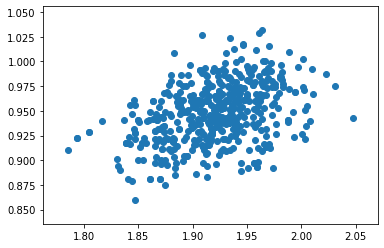

In [11]:
res = hmc_wrapper(5)
plt.scatter(res[500:, 0], res[500:, 1])
plt.savefig("hmc_res")

In [12]:
result_hmc = []
for step in range(10, 100, 10):
    result_hmc.append(hmc_wrapper(step))

In [13]:
def autocorr(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x, axis=0)
    var=np.var(x, axis=0)
    xp=x-mean
    #print(xp)
    corr=[1. if l==0 else np.sum(xp[l:] * xp[:-l]/(len(x) - l)/var) for l in lags]
    #print(corr)
    return np.array(corr)

In [17]:
def hmc_sample_wrapper(step):
    beta = np.array([0.0, 0.0])
    res_beta = []
    for i in range(1000):
        beta = hmc(beta, X, Y, step, 0.01, True)
        res_beta.append(list(beta))

    res_beta = np.array(res_beta)

    return res_beta

result_hmc_sample = []
for step in range(10, 100, 10):
    result_hmc_sample.append(hmc_sample_wrapper(step))

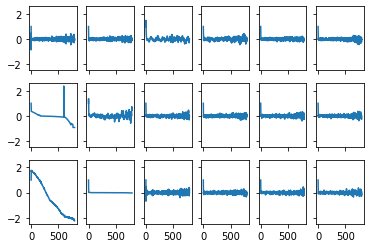

In [28]:
fig, axs = plt.subplots(3, 6, sharex=True, sharey=True)
idx = 0
for res in result_hmc:
    #print(res)
    #print(autocorr(res, range(1000)))
    axs[idx // 3, idx % 3].plot(autocorr(res[100:], range(900))[:800])
    idx += 1
#plt.show()
#plt.savefig("HMC_step")

idx = 0
for res in result_hmc_sample:
    #print(res)
    #print(autocorr(res, range(1000)))
    axs[idx // 3, idx % 3 + 3].plot(autocorr(res[100:], range(900))[:800])
    idx += 1
plt.show()
fig.savefig("HMC_step")

In [ ]:
import pickle
beta = np.array([0.0, 0.0])
res_beta = []
for i in range(100000):
    beta = hmc(beta, X, Y, 5, 0.01)
    res_beta.append(list(beta))

with open("./hmc_gt", "wb") as f:
    pickle.dump(res_beta, f)
    
#with open("./hmc_gt", "rb") as f:
#    print(pickle.load(f))


In [85]:
def get_batch(X, Y, batch_size):
    n = X.shape[0]
    start_ele = np.random.randint(0, n)
    if start_ele + batch_size >= n:
        X_batch = np.concatenate((X[start_ele: ], X[ :start_ele + batch_size - n]))
        Y_batch = np.concatenate((Y[start_ele: ], Y[ :start_ele + batch_size - n]))
    else:
        X_batch = X[start_ele: (start_ele + batch_size)]
        Y_batch = Y[start_ele: (start_ele + batch_size)]
    return X_batch, Y_batch

In [170]:
def sgld(beta, X, Y, num_step, epsilon, batch_size):
    momentum = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])
    for i in range(num_step):
        X_b, Y_b = get_batch(X, Y, batch_size)
        noise = np.random.multivariate_normal([0, 0], [[epsilon, 0], [0, epsilon]])
        momentum -= epsilon/2 * grad_potential_energy(beta, X_b, Y_b) + noise
        beta += epsilon * momentum
    return beta

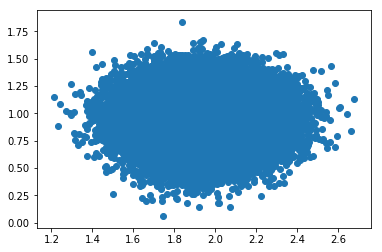

In [171]:
def lr_scheduler(lr_init, step, decay):
    warm_up_step = 100.0
    lr_decay = 1e-6
    if step <= warm_up_step:
        return lr_init * step / warm_up_step
    if not decay:
        return lr_init
    return np.power(1 - lr_decay, step - 100) * lr_init

beta = np.array([0.0, 0.0])
res_beta = []
for i in range(100000):
    lr = lr_scheduler(0.01, i, True)
    beta = sgld(beta, X, Y, 5, lr, 32)
    res_beta.append(list(beta))

res_beta = np.array(res_beta)

with open("./sgld_gt", "wb") as f:
    pickle.dump(res_beta, f)

#print(np.mean(res_beta[5000:, :], axis = 0))

plt.scatter(res_beta[50000:, 0], res_beta[50000:, 1])

In [177]:
def sghmc(beta, X, Y, num_step, epsilon, batch_size):
    # what is C?
    momentum = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])
    for i in range(num_step):
        noise = np.sqrt(2 * 10) * np.random.multivariate_normal([0, 0], [[epsilon, 0], [0, epsilon]])
        X_b, Y_b = get_batch(X, Y, batch_size)
        beta += epsilon * momentum
        momentum -= epsilon * grad_potential_energy(beta, X_b, Y_b) + epsilon  * 10 * momentum + noise
    return beta

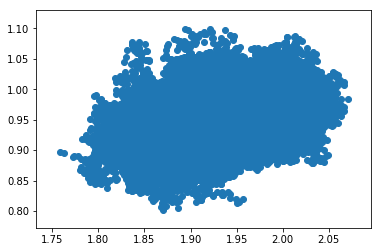

In [182]:
beta = np.array([0.0, 0.0])
res_beta = []
for i in range(100000):
    lr = lr_scheduler(0.001, i, True)
    beta = sghmc(beta, X, Y, 5, lr, 32)
    res_beta.append(list(beta))

res_beta = np.array(res_beta)

with open("./sghmc_gt", "wb") as f:
    pickle.dump(res_beta, f)

#print(np.mean(res_beta[5000:, :], axis = 0))

plt.scatter(res_beta[50000:, 0], res_beta[50000:, 1])

In [150]:
def sgnht(beta, X, Y, num_step, epsilon, batch_size):
    momentum = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]])
    xi = 1.0
    for i in range(num_step):
        noise = np.sqrt(2 * 10) * np.random.multivariate_normal([0, 0], [[epsilon, 0], [0, epsilon]])
        X_b, Y_b = get_batch(X, Y, batch_size)
        momentum -= epsilon * grad_potential_energy(beta, X_b, Y_b) + epsilon * xi * momentum + noise
        beta += epsilon * momentum
        xi += epsilon * (momentum.T @ momentum / 2 - 1)
    return beta

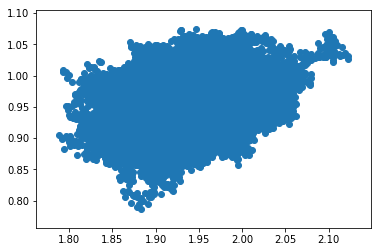

In [184]:
beta = np.array([0.0, 0.0])
res_beta = []
for i in range(100000):
    lr = lr_scheduler(0.001, i, True)
    beta = sgnht(beta, X, Y, 5, lr, 32)
    res_beta.append(list(beta))

res_beta = np.array(res_beta)

with open("./sgnht_gt", "wb") as f:
    pickle.dump(res_beta, f)

#print(np.mean(res_beta[5000:, :], axis = 0))

plt.scatter(res_beta[50000:, 0], res_beta[50000:, 1])

In [2]:
from ite.cost import BDKL_KnnK
import pickle

In [3]:
co = BDKL_KnnK()

In [4]:
res_hmc = []
with open("./hmc_gt", "rb") as f:
    res_hmc = pickle.load(f)

res_hmc = np.array(res_hmc)[50000:]

In [5]:
res_gt = []
for i in range(100):
    res_gt.append(res_hmc[i * 500])
res_gt = np.array(res_gt)

In [6]:
from scipy.ndimage.filters import gaussian_filter1d


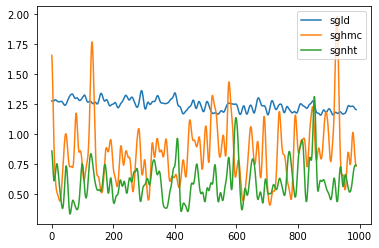

In [9]:
res_sgld = []
with open("./sgld_gt", "rb") as f:
    res_sgld = pickle.load(f)

d_sgld = []
for i in range(500, 99500, 100):
    d_sgld.append(co.estimation(res_sgld[i-500:i+500], res_gt))
    
d_sgld = gaussian_filter1d(d_sgld, sigma=4)
plt.plot(d_sgld)

res_sghmc = []
with open("./sghmc_gt", "rb") as f:
    res_sghmc = pickle.load(f)
    
d_sghmc = []
for i in range(500, 99500, 100):
    d_sghmc.append(co.estimation(res_sghmc[i-500:i+500], res_gt))
    
d_sghmc = gaussian_filter1d(d_sghmc, sigma=4)
plt.plot(d_sghmc)

res_sgnht = []
with open("./sgnht_gt", "rb") as f:
    res_sgnht = pickle.load(f)
    
d_sgnht = []
for i in range(500, 99500, 100):
    d_sgnht.append(co.estimation(res_sgnht[i-500:i+500], res_gt))
    
d_sgnht = gaussian_filter1d(d_sgnht, sigma=4)
plt.plot(d_sgnht)
plt.legend(['sgld', 'sghmc', 'sgnht'], loc='upper right')
plt.savefig("SGHMC")
plt.show()

In [169]:
print(np.mean(d_sgld), np.mean(d_sghmc), np.mean(d_sgnht))

0.5358208047737343 0.7396405547614279 0.520075451710689
